### Notebook to make the figure showing the classes uncovered by LCTA

In [1]:
using DataFrames
using RData
using CairoMakie
using Statistics
using CSV

In [2]:
file_path_parameters = "../../Data/parameters_flexmix_model_02.RData"

flexmix_parameters = RData.load(file_path_parameters)["params_0.2"]
k5_params = flexmix_parameters[1]
k6_params = flexmix_parameters[2]

file_path_data = "../../Data/robustness_fit_mult_0.2.CSV"

data = CSV.read(file_path_data, DataFrame)
clusters = data[:,:assignment]
k5 = data[:,:k5]
k6 = data[:,:k6]
time = data[:,:time];

In [7]:
using CairoMakie, Statistics

# Extract data
clusters = data[:, :assignment]  # 500-element vector
k5 = data[:, :k5]                # 500-element vector
k6 = data[:, :k6]                # 500-element vector
time = data[:, :time]            # 500-element vector

# Reshape clusters into a 100-element vector (one cluster per person)
clusters_per_person = clusters[1:5:end]

# Get unique clusters and Wong colors
unique_clusters = unique(clusters_per_person)
colors = Makie.wong_colors()

# Set up the figure with two subplots
fig = Figure(size = (1000, 400))

# First subplot for k5
ax1 = Axis(fig[1, 1], xlabel = "τ (years)", ylabel = "k5", 
           xticklabelsize = 14, yticklabelsize = 14, xlabelsize = 20, ylabelsize = 16, 
           xlabelfont = :bold, ylabelfont = :bold)

# Second subplot for k6
ax2 = Axis(fig[1, 2], xlabel = "τ (years)", ylabel = "k6", 
           xticklabelsize = 14, yticklabelsize = 14, xlabelsize = 20, ylabelsize = 16, 
           xlabelfont = :bold, ylabelfont = :bold)

# Function to calculate mean and CI over time
function calculate_mean_and_ci(data, clusters, time_points)
    unique_clusters = unique(clusters)
    unique_times = unique(time_points)
    ci_lower = Dict()
    ci_upper = Dict()

    for cluster in unique_clusters
        lower_val = Float64[]
        upper_val = Float64[]
        for t in unique_times
            idx = (clusters .== cluster) .& (time_points .== t)
            cluster_data = data[idx]
            if !isempty(cluster_data)
                n = length(cluster_data)
                mean_t = mean(cluster_data)
                std_t = std(cluster_data)
                ci = 1.96 * std_t / sqrt(n)
                push!(lower_val, mean_t - ci)
                push!(upper_val, mean_t + ci)
            else
                push!(lower_val, NaN)
                push!(upper_val, NaN)
            end
        end
        ci_lower[cluster] = lower_val
        ci_upper[cluster] = upper_val
    end
    return ci_lower, ci_upper, unique_times
end

# Calculate CI for k5 and k6 over time
ci_lower_k5, ci_upper_k5, unique_times = calculate_mean_and_ci(k5, clusters, time)
ci_lower_k6, ci_upper_k6, _ = calculate_mean_and_ci(k6, clusters, time)

# Function to plot fixed effects
function plot_fixed_effects(ax, intercepts, linear_coeffs, quadratic_coeffs, time_points, label_prefix)
    for i in 1:length(unique_clusters)
        mean_traj = intercepts[i] .+ linear_coeffs[i] .* time_points .+ quadratic_coeffs[i] .* (time_points .^ 2)
        lines!(ax, time_points, mean_traj, color = colors[i], linewidth = 2, label = "$label_prefix Cluster $i", alpha = 0.8)
    end
end
times_lines = range(0,4, length= 100)
# Plot k5 fixed effects and data-derived CI
plot_fixed_effects(ax1, k5_params[1, :], k5_params[2, :], k5_params[3, :], times_lines, "k5")
for (i, cluster) in enumerate(unique_clusters)
    band!(ax1, unique_times, ci_lower_k5[cluster], ci_upper_k5[cluster], color = (colors[i], 0.3))
end

# Plot k6 fixed effects and data-derived CI
plot_fixed_effects(ax2, k6_params[1, :], k6_params[2, :], k6_params[3, :], times_lines, "k6")
for (i, cluster) in enumerate(unique_clusters)
    band!(ax2, unique_times, ci_lower_k6[cluster], ci_upper_k6[cluster], color = (colors[i], 0.3))
end

# Create a custom legend
legend_elements = [
    LineElement(color = colors[i], linewidth = 2) for i in 1:length(unique_clusters)
]
legend_labels = vcat(["Healthy", "T2DM", "Insulin resistance", "β-cell dysfunction"])

# Add legend to the right of the plots
Legend(fig[1, 3], legend_elements, legend_labels,"True class", titlesize = 20, titlefont = :bold, labelsize = 20,  titleposition = :top)

# Show the figure
fig

# Save the figure
save("LCTA_fixed_effects_noisydata.png", fig)

CairoMakie.Screen{IMAGE}


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\20192809\.julia\packages\Makie\VRavR\src\scenes.jl:220


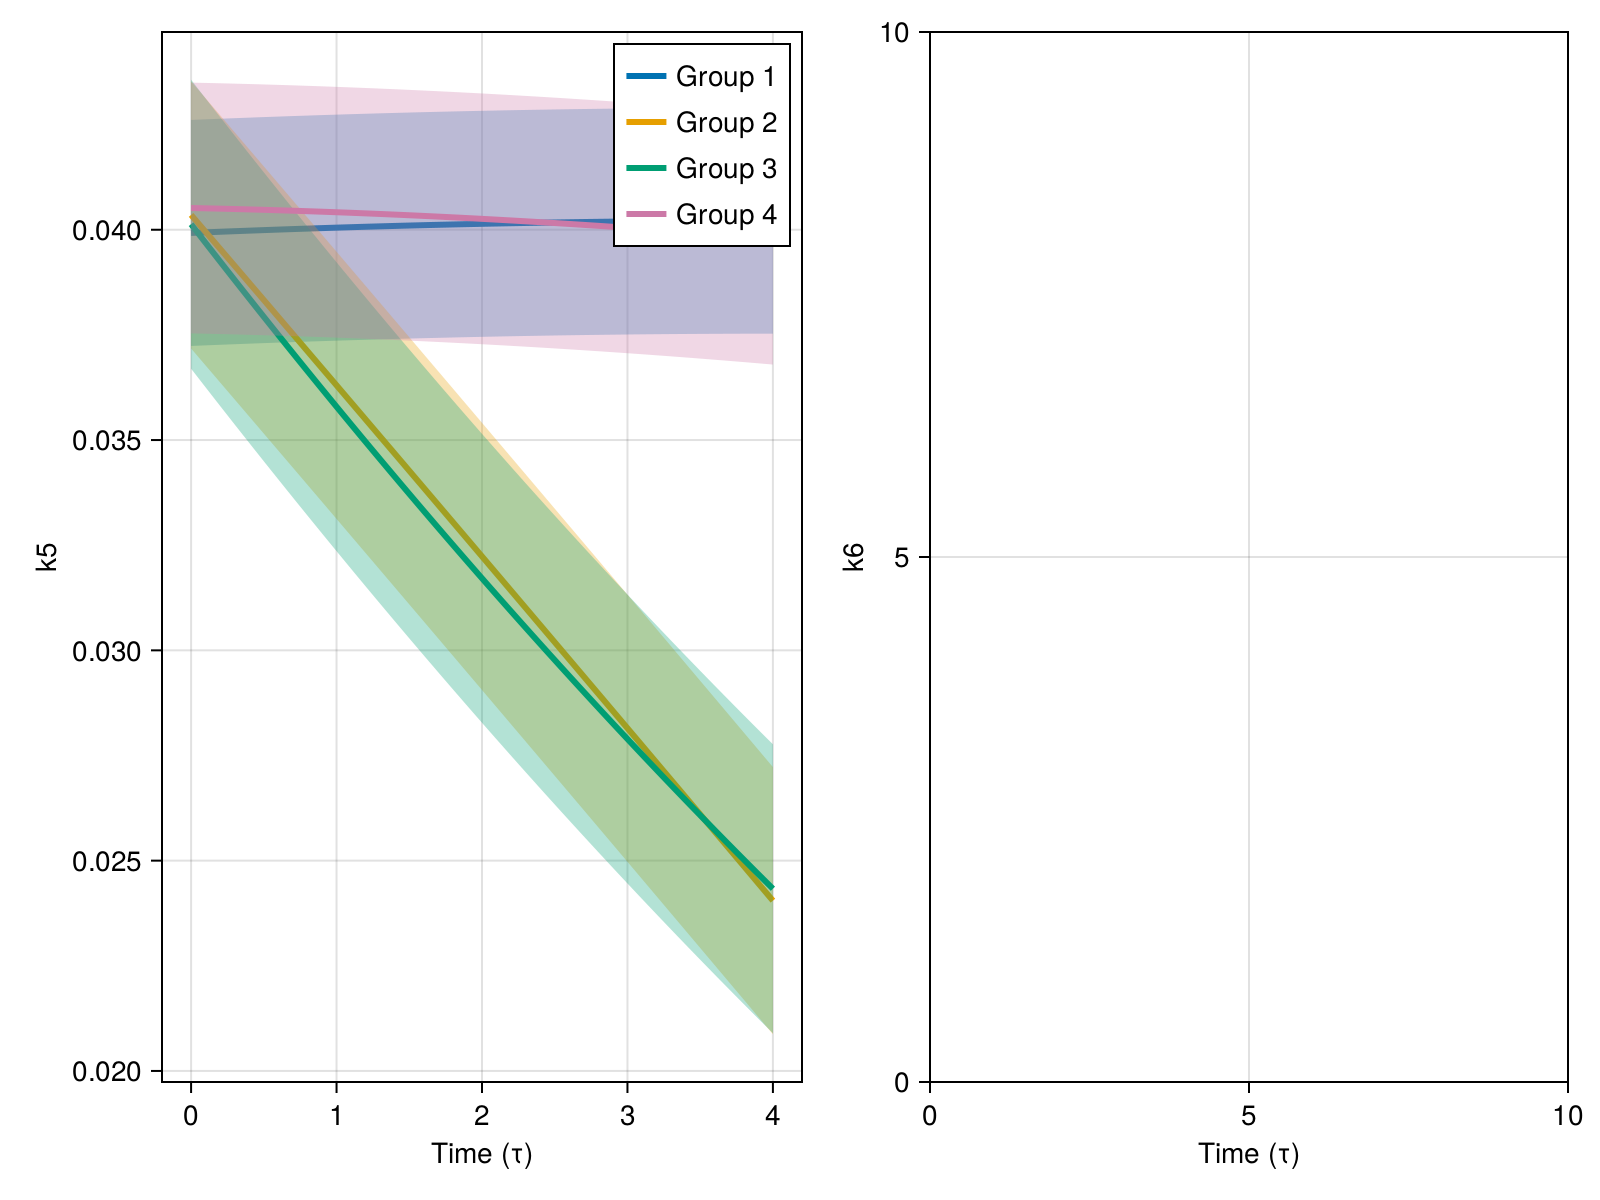

In [ ]:
# using CairoMakie

# # Define time points
# time_points = range(0, 4, length=200)

# # Extract coefficients
# intercepts_k5 = k5_params[1, :]
# linear_coeffs_k5 = k5_params[2, :]
# quadratic_coeffs_k5 = k5_params[3, :]
# random_variances_k5 = k5_params[4, :]  # Assuming row 4 contains sigma2.Random
# residual_variances_k5 = k5_params[5, :]  # Assuming row 5 contains sigma2.Residual

# # Compute k1 trajectories and confidence intervals
# k5_trajectories = []
# upper_bounds = []
# lower_bounds = []

# for i in 1:4
#     mean_traj = intercepts_k5[i] .+ linear_coeffs_k5[i] .* time_points .+ quadratic_coeffs_k5[i] .* (time_points .^ 2)
#     push!(k5_trajectories, mean_traj)

#     # Compute total standard deviation
#     sigma_total = sqrt(random_variances_k5[i] + residual_variances[i])

#     # Compute confidence bands (±2 std)
#     push!(upper_bounds, mean_traj .+ 2 * sigma_total)
#     push!(lower_bounds, mean_traj .- 2 * sigma_total)
# end

# # Define colors
# colors = Makie.wong_colors()[1:4]

# # Plot
# fig = Figure(resolution=(800, 600))
# ax1 = Axis(fig[1, 1], xlabel="Time (τ)", ylabel="k5")
# ax2 = Axis(fig[1,2], xlabel="Time (τ)", ylabel="k6")

# for i in 1:4
#     band!(ax1, time_points, lower_bounds[i], upper_bounds[i], color=(colors[i], 0.3))  # 30% opacity
#     lines!(ax1, time_points, k5_trajectories[i], color=colors[i], linewidth=3, label="Group $i")
# end

# # ylims!(ax, 0.012, 0.018)
# # xlims!(ax, 0 , 30)
# axislegend(ax1)

# fig

In [ ]:
using CairoMakie, Statistics

# Extract data
clusters = data[:, :assignment]  # 500-element vector
k5 = data[:, :k5]                # 500-element vector
k6 = data[:, :k6]                # 500-element vector
time = data[:, :time]            # 500-element vector

# Reshape clusters into a 100-element vector (one cluster per person)
clusters_per_person = clusters[1:5:end]

# Get unique clusters and Wong colors
unique_clusters = unique(clusters_per_person)
colors = Makie.wong_colors()

# Set up the figure with two subplots
fig = Figure(size = (1000, 400))  # Adjusted width to accommodate the legend

# First subplot for k5
ax1 = Axis(fig[1, 1], xlabel = "τ", ylabel = "k5", 
           xticklabelsize = 14, yticklabelsize = 14, xlabelsize = 20, ylabelsize = 16, 
           xlabelfont = :bold, ylabelfont = :bold)

# Second subplot for k6
ax2 = Axis(fig[1, 2], xlabel = "τ", ylabel = "k6", 
           xticklabelsize = 14, yticklabelsize = 14, xlabelsize = 20, ylabelsize = 16, 
           xlabelfont = :bold, ylabelfont = :bold)

# Function to calculate mean and confidence intervals over time
function calculate_mean_and_ci_over_time(data, clusters, time_points)
    unique_clusters = unique(clusters)
    unique_times = unique(time_points)
    mean_values = Dict()
    ci_lower = Dict()
    ci_upper = Dict()
    
    for cluster in unique_clusters
        mean_val = Float64[]  # Explicitly typed as Vector{Float64}
        lower_val = Float64[]  # Explicitly typed as Vector{Float64}
        upper_val = Float64[]  # Explicitly typed as Vector{Float64}
        for t in unique_times
            idx = (clusters .== cluster) .& (time_points .== t)
            cluster_data = data[idx]
            if !isempty(cluster_data)
                n = length(cluster_data)
                mean_t = mean(cluster_data)
                std_t = std(cluster_data)
                ci = 1.96 * std_t / sqrt(n)  # 95% confidence interval
                push!(mean_val, mean_t)
                push!(lower_val, mean_t - ci)
                push!(upper_val, mean_t + ci)
            else
                push!(mean_val, NaN)
                push!(lower_val, NaN)
                push!(upper_val, NaN)
            end
        end
        mean_values[cluster] = mean_val
        ci_lower[cluster] = lower_val
        ci_upper[cluster] = upper_val
    end
    return mean_values, ci_lower, ci_upper, unique_times
end

# Calculate mean and CI for k5 and k6 over time
mean_k5, ci_lower_k5, ci_upper_k5, unique_times = calculate_mean_and_ci_over_time(k5, clusters, time)
mean_k6, ci_lower_k6, ci_upper_k6, _ = calculate_mean_and_ci_over_time(k6, clusters, time)

# Plot k5 with mean and confidence intervals over time
for (i, cluster) in enumerate(unique_clusters)
    lines!(ax1, unique_times, mean_k5[cluster], color = colors[i], linewidth = 2, label = "Cluster $cluster", alpha =0.8)
    band!(ax1, unique_times, ci_lower_k5[cluster], ci_upper_k5[cluster], color = (colors[i], 0.2))
end

# Plot k6 with mean and confidence intervals over time
for (i, cluster) in enumerate(unique_clusters)
    lines!(ax2, unique_times, mean_k6[cluster], color = colors[i], linewidth = 2, label = "Cluster $cluster", alpha =0.8)
    band!(ax2, unique_times, ci_lower_k6[cluster], ci_upper_k6[cluster], color = (colors[i], 0.2))
end

# Create a custom legend
legend_elements = [
    LineElement(color = colors[1], linewidth = 2),  # Cluster 1
    LineElement(color = colors[2], linewidth = 2),  # Cluster 2
    LineElement(color = colors[3], linewidth = 2),  # Cluster 3
    LineElement(color = colors[4], linewidth = 2),  # Cluster 4
]

legend_labels = ["Cluster $i" for i in 1:length(unique_clusters)]

# Add legend to the right of the plots
Legend(fig[1, 3], legend_elements, legend_labels, label_size = 16)

# Show the figure
fig

# Save the figure
# save("robustness_fit_mult_0.2.png", fig)